# Creating Animations with `matplotlib`

[back to overview page](index.ipynb)

There's a very good blog post by Jake Vanderplas: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/.
Note, however, that the `init()` functions used by Jake are actually not necessary!

For reference, consult the matplotlib animation docs: http://matplotlib.org/api/animation_api.html.

If you want to use SymPy, have a look at
[the notebook about SymPy animations](../sympy/sympy-matplotlib-animations.ipynb).

This notebook shows how to create an animation using *head related impulse responses* (HRIRs), very similar to the animation on http://www.gnuplotting.org/animation-iii-video-revisited/.

First, we import the typical NumPy/matplotlib stuff ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

... and a special class for our animation:

In [2]:
from matplotlib.animation import FuncAnimation

The data we are using is originally stored in a `.mat` file, therefore we need the [loadmat()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) function from SciPy:

In [3]:
from scipy.io import loadmat

Let's download the HRIR data from https://dev.qu.tu-berlin.de/projects/measurements/wiki/2010-11-kemar-anechoic:

In [4]:
import io
from urllib.request import urlopen

url =  'https://dev.qu.tu-berlin.de/projects/measurements/repository/raw/2010-11-kemar-anechoic/mat/QU_KEMAR_anechoic_2m.mat'
file = io.BytesIO(urlopen(url).read())

# If you want to open a local file instead:
#file = 'QU_KEMAR_anechoic_2m.mat'

By default, the data structure obtained from a `.mat` file is quite clunky, the options `struct_as_record=False` and `squeeze_me=True` make it somewhat easier to handle.

In [5]:
irs = loadmat(file, struct_as_record=False, squeeze_me=True)['irs']

In [6]:
irs._fieldnames

['description',
 'head',
 'ears',
 'room',
 'source',
 'distance',
 'fs',
 'head_position',
 'head_reference',
 'source_position',
 'source_reference',
 'head_azimuth',
 'head_elevation',
 'torso_azimuth',
 'torso_elevation',
 'apparent_azimuth',
 'apparent_elevation',
 'left',
 'right']

There are several fields in the data structure `irs`, we'll be using these:

field name | contents
-----------|---------
left | impulse responses for the left ear
right | impulse responses for the right ear
fs | sampling rate
apparent_azimuth | directions of sound incidence (in radians)

The actual impulse responses are stored as columns. There is one column for each angle of incidence.

In [7]:
irs.left.shape, irs.right.shape

((2048, 360), (2048, 360))

To get an idea how the data looks like, let's plot all the columns in `irs.left`:

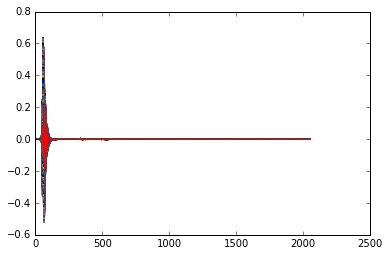

In [8]:
plt.plot(irs.left);

It looks like the most interesting part is in the beginning ...

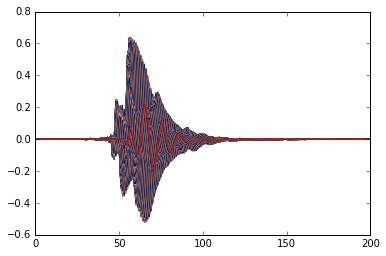

In [9]:
plt.plot(irs.left[:200]);

We can still get a little closer ... let's cut out the interesting piece of the impulse responses:

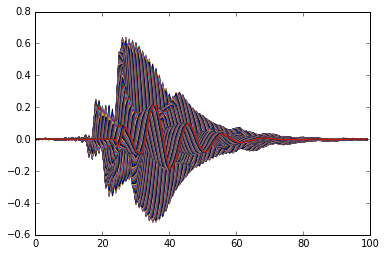

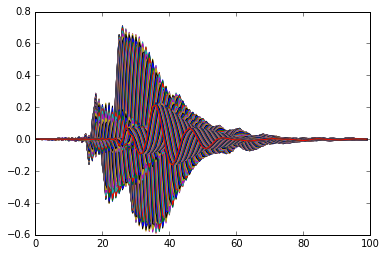

In [10]:
selection = slice(30, 130)

left = irs.left[selection]
right = irs.right[selection]
fs = irs.fs

plt.plot(left)
plt.figure()
plt.plot(right);

Now let's look at a single impulse reponse:

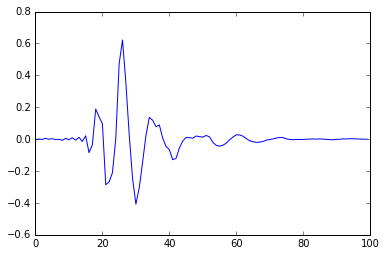

In [11]:
plt.plot(left[:, 270]);

This looks a bit jagged, probably we can make it a bit smoother by oversampling?

In [12]:
from scipy import signal

upsampling_factor = 4
left = signal.resample(left, upsampling_factor * len(left), axis=0)
right = signal.resample(right, upsampling_factor * len(right), axis=0)
fs = upsampling_factor * fs

Note that the [resample()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) function assumes the input signal to be periodic (which doesn't apply in our case!), therefore our result isn't quite correct!
Since we are only using this for plotting, that's OK, but for any *serious* signal processing tasks involving resampling, you should read up on the details!

Let's see how the re-sampled signal looks:

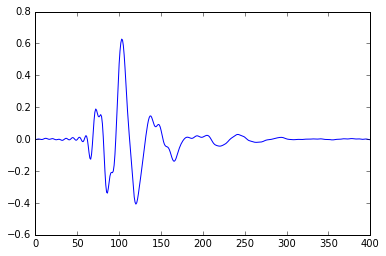

In [13]:
plt.plot(left[:, 270]);

OK, that looks much smoother.

The x-axis shows the time in samples, to get the time in milliseconds, we have to specify an array of time instants:

In [14]:
t = np.arange(len(left)) * 1000 / fs  # time in milliseconds

The left impulse response shall appear above the right one, so we shift the left one a bit towards the top and the right one towards the bottom:

In [15]:
shift = 0.5

left += shift
right -= shift

Now we can fine-tune how one of the frames is going to look like in detail:

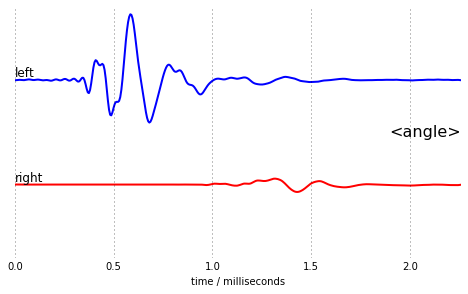

In [16]:
idx = 270
amplitude = 0.7

fig, ax = plt.subplots(figsize=(8, 4.5))
line1, = ax.plot(t, left[:, idx], linewidth=2, color='blue')
line2, = ax.plot(t, right[:, idx], linewidth=2, color='red')
ax.axis([t.min(), t.max(), -(shift + amplitude), shift + amplitude])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.xaxis.grid()
ax.yaxis.set_ticks([])

text = ax.text(t.max(), 0, '<angle>', fontsize=16,
               horizontalalignment='right', verticalalignment='center')
ax.text(0, shift, 'left', fontsize=12,
        horizontalalignment='left', verticalalignment='bottom')
ax.text(0, -shift, 'right', fontsize=12,
        horizontalalignment='left', verticalalignment='bottom')
ax.set_xlabel("time / milliseconds");

OK. Now that we have one frame of our animation, we just need a function that is called for each frame to make any changes that are necessary for the current frame.

In [17]:
def animation_func(idx):
    line1.set_ydata(left[:, idx])
    line2.set_ydata(right[:, idx])
    text.set_text('{:g}Â°'.format(np.rad2deg(irs.apparent_azimuth[idx])))
    return line1, line2, text  # only necessary for blit=True

In [18]:
ani = FuncAnimation(fig, animation_func, frames=left.shape[1],
                    blit=True, interval=60)

Note that the option `blit=True` can be used to make the display in a plot window more efficient.
For that to work, the animation function has to return all plot objects that it manipulates.

Setting `blit=True` has no effect when using `save()` (as it is used below).

Use `plt.show()` to open a plotting window and show the animation.
However, within a Jupyter notebook this doesn't really work well, so it might be better to save the animation to a separate video file:

In [19]:
ani.save('hrir.mp4', codec='h264')

The [generated video](hrir.mp4) can be shown within the notebook using the HTML5 `<video>` tag like this:

```html
<video src=hrir.mp4 controls loop>video tag not supported</video>
```

And this is how the video looks like:

<video src=hrir.mp4 controls loop>video tag not supported</video>

Alternatively, the animation can be embedded in the Jupyter notebook as an inline video
(using [to_html5_video()](http://matplotlib.org/api/_as_gen/matplotlib.animation.Animation.html#matplotlib.animation.Animation.to_html5_video))
or as JavaScript animation
(using [to_jshtml()](http://matplotlib.org/api/_as_gen/matplotlib.animation.Animation.html#matplotlib.animation.Animation.to_jshtml)).

## Further Reading

http://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>